In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from RaTag.scripts.wfm2read_fast import wfm2read
from RaTag.scripts.wfm2spectra import get_peak_volts, histogram_voltages

# Reconstruct spectrum from raw waveforms (.csv)

In [94]:
def waveforms2channels(files):
    vmax = []
    for file in files:
        df = pd.read_csv(file, header=None, names=['time', 'voltage'], skiprows=6, )
    # df.set_index('time', inplace=True, drop=True)
        vmax.append(df['voltage'].max() - df['voltage'].min())

    channels = [v * 2048 / 10 for v in vmax]  # Convert to ADC counts
    plt.hist(channels, bins=100, range=(0, 2048), );
    plt.gca().set(xlabel='ADC Counts', ylabel='Number of Channels',)

    return channels

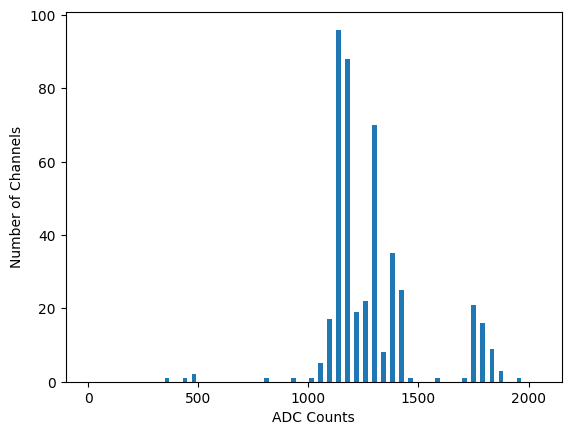

In [95]:
# ROOT_DIR = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-pablo.herrero-gomez@mail.huji.ac.il/My Drive/RaTag_data/scope_data/' 
ROOT_DIR = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/'
files = glob(ROOT_DIR + '*.csv')
channels = waveforms2channels(files)

[Text(0.5, 0, 'Energy channel (arb. units)'),
 Text(0, 0.5, 'Counts'),
 Text(0.5, 1.0, 'Energy channel from waveforms')]

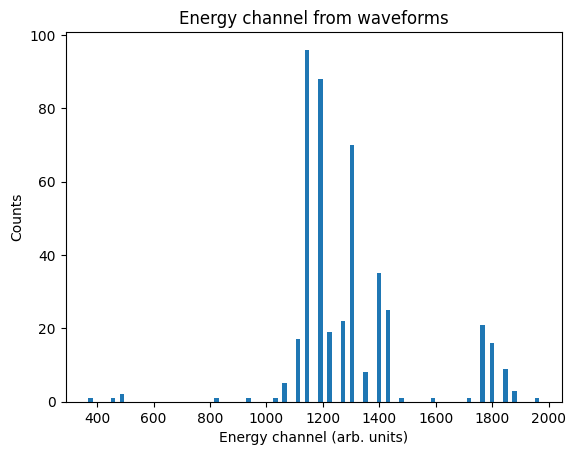

In [115]:
plt.hist(channels, bins=100, );
plt.gca().set(xlabel='Energy channel (arb. units)', ylabel='Counts', title='Energy channel from waveforms')

[Text(0.5, 0, 'Voltage (V)'),
 Text(0, 0.5, 'Counts'),
 Text(0.5, 1.0, 'Voltage from waveforms')]

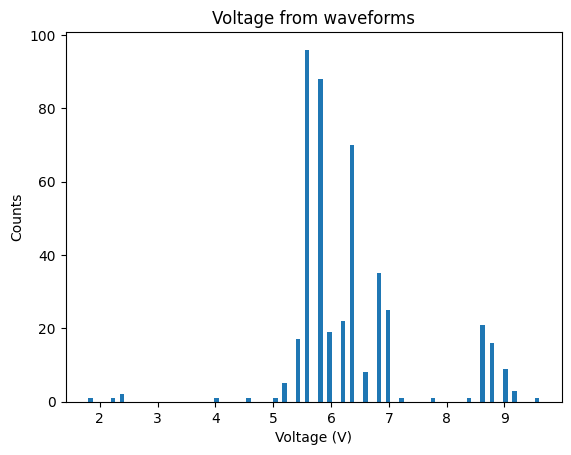

In [116]:
vmax = [c / 2048 * 10 for c in channels]  # Convert to ADC counts
plt.hist(vmax, bins=100);
plt.gca().set(xlabel='Voltage (V)', ylabel='Counts', title='Voltage from waveforms')

# Reconstruct full spectrum from peak2peak measurement 

(much lighter, more counts)

## No SCA

In [ ]:
def peak2peak2channels(files):
    vmax = []
    for file in files:
        df = pd.read_csv(file, header=None, names=['time', 'voltage'], skiprows=6, )

        vmax.append(df['Pk-Pk'].values)

    channels = [v * 2048 / 10 for v in vmax]  # Convert to ADC counts
    plt.hist(channels, bins=100, range=(0, 2048), );
    plt.gca().set(xlabel='ADC Counts', ylabel='Number of Channels',)

    return channels

In [ ]:
ROOT_DIR = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/peak2peak/noSCA/'
files = glob(ROOT_DIR + '*.csv')
voltages = []
for file in files:
    p2p = pd.read_csv(file, header=None, names=['val', 'mean', 'min', 'max', 'std', 'count', 'info', 'units',]).iloc[2,0]
    voltages.append(p2p)

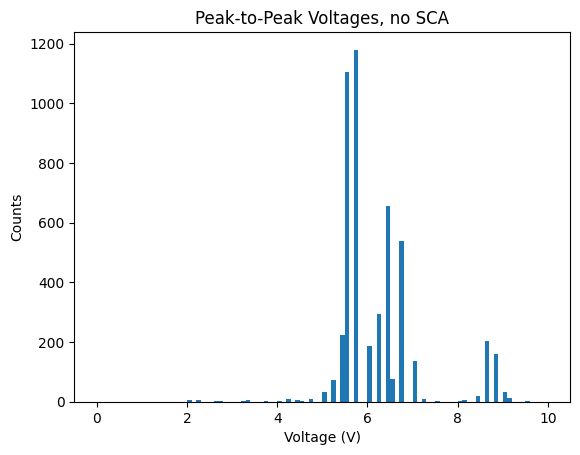

In [118]:
plt.hist(voltages, bins=100, range=(0, 10));
plt.gca().set(xlabel='Voltage (V)', ylabel='Counts', title='Peak-to-Peak Voltages, no SCA');

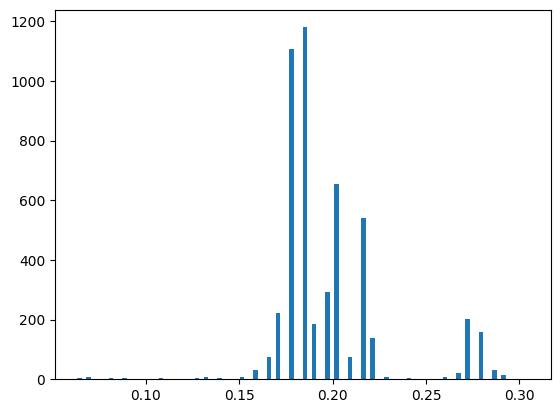

In [183]:
preamps = [v / get_total_gain(63, coarse_gain=50) for v in voltages]  
plt.hist(preamps, bins=100, );

In [158]:
def get_total_gain(dial, coarse_gain = 50):
    Gmin = 0.5
    Gmax = 1.5
    dmin = 50
    dmax = 150
    Gfine = Gmin + (Gmax - Gmin) * (dial - dmin) / (dmax - dmin)
    Gtotal = Gfine * coarse_gain
    return Gtotal

def voltage2energy(V, fine_gain = 63, coarse_gain = 50):
    """
    Convert a channel number to voltage and energy peak.
    :param V: voltage in volts
    :param fine_gain: Fine gain setting (0-63)
    :param coarse_gain: Coarse gain setting (default 50)
    :return: Tuple of voltage in mV and energy peak in eV
    """
    assert coarse_gain in [50, 100, 200, 500, 10000], "Coarse gain must be one of [50, 100, 200, 500, 10000]"

    gain_amp = get_total_gain(fine_gain, coarse_gain)
    gain_preamp = 45 # mV / MeV preamp gain

    V_mV = V * 1000 # mV

    E_peak = V_mV / (gain_amp * gain_preamp) # MeV

    # print(f"V = {V:.2f} V")
    # print(f"E_peak = {E_peak:.2f} MeV")
    return V_mV, E_peak

In [159]:
get_total_gain(63, 50)  

31.5

In [174]:
V = 240 # mV
c_sensitivity = 45 # mV/MeV
E = V / c_sensitivity # MeV
print(f"Voltage: {V} mV, Energy: {E:.2f} MeV")

Voltage: 240 mV, Energy: 5.33 MeV


In [180]:
E = 8.2 # MeV
c_sensitivity = 45 # mV/MeV
V_pre = E * c_sensitivity # mV
V_amp = V_pre * get_total_gain(63, 50) # mV
print(f"Voltage pre amp: {V_pre} mV, amp: {V_amp}, Energy: {E:.2f} MeV")

Voltage pre amp: 368.99999999999994 mV, amp: 11623.499999999998, Energy: 8.20 MeV


In [176]:
Vamp = V * get_total_gain(63, coarse_gain=50) 
Vamp


7560.0

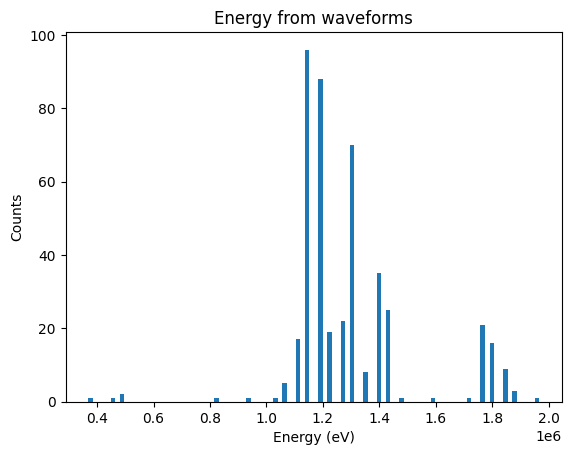

In [177]:
energies = [voltage2energy(c, fine_gain=63, coarse_gain=50)[0] for c in channels]
plt.hist(energies, bins=100, );
plt.gca().set(xlabel='Energy (eV)', ylabel='Counts', title='Energy from waveforms');

## SCA 5-7 V

In [164]:
ROOT_DIR = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/peak2peak/SCA_5-7V/'
files = sorted(glob(ROOT_DIR + '*.csv'))
voltages_sca1 = []
for file in files:
    p2p = pd.read_csv(file, header=None, names=['val', 'mean', 'min', 'max', 'std', 'count', 'info', 'units',]).iloc[2,0]
    voltages_sca1.append(p2p)

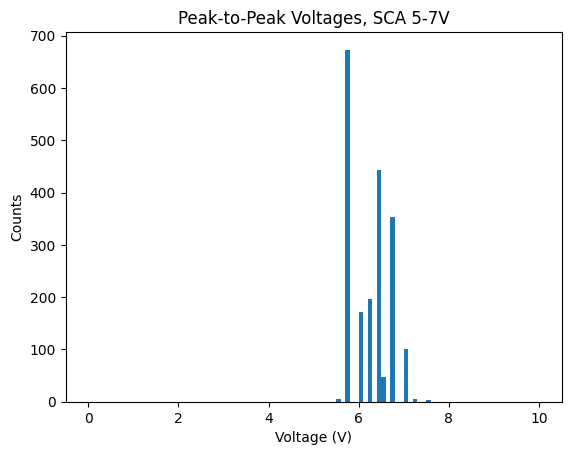

In [165]:
plt.hist(voltages_sca1, bins=100, range=(0, 10));
plt.gca().set(xlabel='Voltage (V)', ylabel='Counts', title='Peak-to-Peak Voltages, SCA 5-7V');

[(5.0, 7.0)]

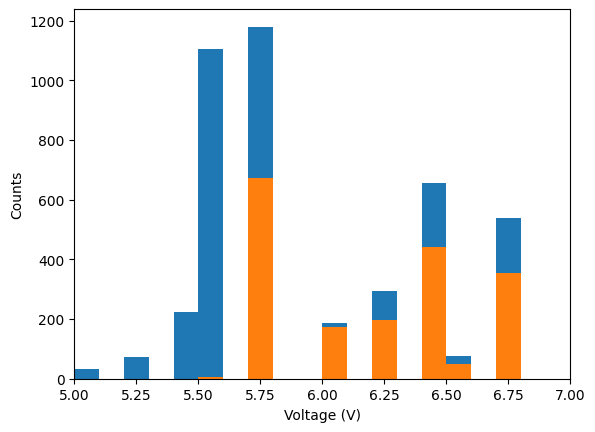

In [143]:
plt.hist(voltages, bins=100, range=(0, 10), label='No SCA');
plt.hist(voltages_sca1, bins=100, range=(0, 10), label='SCA 5-7V');
plt.gca().set(xlabel='Voltage (V)', ylabel='Counts', );
plt.gca().set(xlim=(5, 7), )


## SCA 5.6-6.0V

In [162]:
ROOT_DIR = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/peak2peak/SCA_5.6-6.0V/'
files = sorted(glob(ROOT_DIR + '*.csv'))
voltages_sca2 = []
for file in files:
    p2p = pd.read_csv(file, header=None, names=['val', 'mean', 'min', 'max', 'std', 'count', 'info', 'units',]).iloc[2,0]
    voltages_sca2.append(p2p)

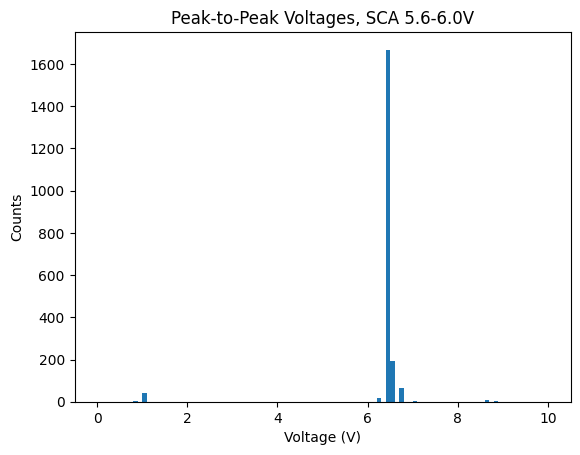

In [163]:
plt.hist(voltages_sca2, bins=100, range=(0, 10));
plt.gca().set(xlabel='Voltage (V)', ylabel='Counts', title='Peak-to-Peak Voltages, SCA 5.6-6.0V');

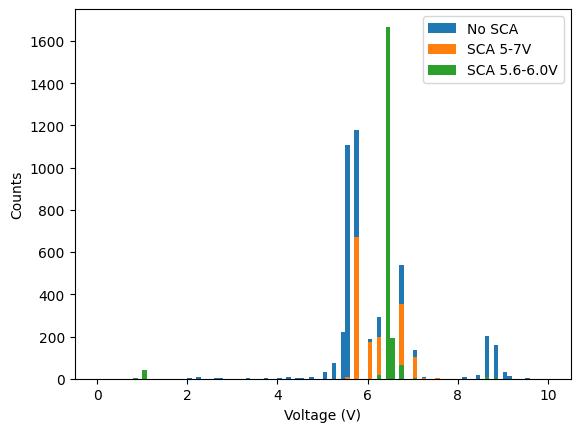

In [168]:
plt.hist(voltages, bins=100, range=(0, 10), label='No SCA');
plt.hist(voltages_sca1, bins=100, range=(0, 10), label='SCA 5-7V');
plt.hist(voltages_sca2, bins=100, range=(0, 10), label='SCA 5.6-6.0V');

plt.gca().set(xlabel='Voltage (V)', ylabel='Counts', );
plt.legend()
# plt.gca().set(xlim=(5, 7), )


# Read multiple binary files

## No SCA

In [21]:
path = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/'
filesbin = sorted(glob(path + '*.wfm'))
filesbin[:3]


['/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_100Wfm.wfm',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_101Wfm.wfm',
 '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_102Wfm.wfm']

In [15]:
y, t, info, ind_over, ind_under = wfm2read(filesbin[0], step=0.001)

Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82/27052025_SCA_4.62-5.82_100Wfm.wfm starting at index 0 with step 0.001


[(0.0, 2e-08)]

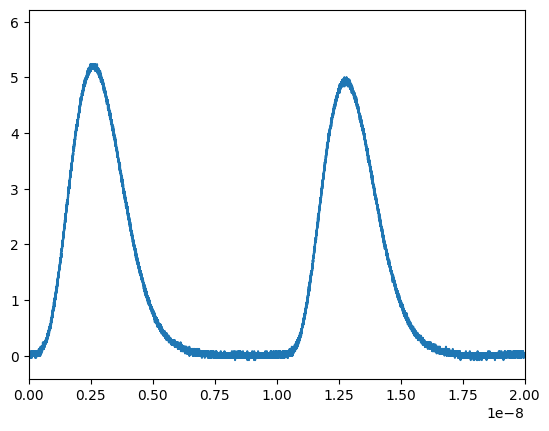

In [19]:
plt.plot(t, y, label='Waveform')
plt.gca().set(xlim=(0, 2e-8))#, xlabel='Time (s)', ylabel='Voltage (V)', title='Waveform from WFM file')

In [22]:
peak_volts = np.array([])
for file in filesbin:
    peak_volts = np.append(peak_volts, get_peak_volts(file))


Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_100Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_101Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_102Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_103Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_104Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/27052025_noSCA_105Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 

In [23]:
pathout = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/noSCA/peaks_out.csv'
np.savetxt(pathout, peak_volts)

In [42]:
len(peak_volts)

1134604

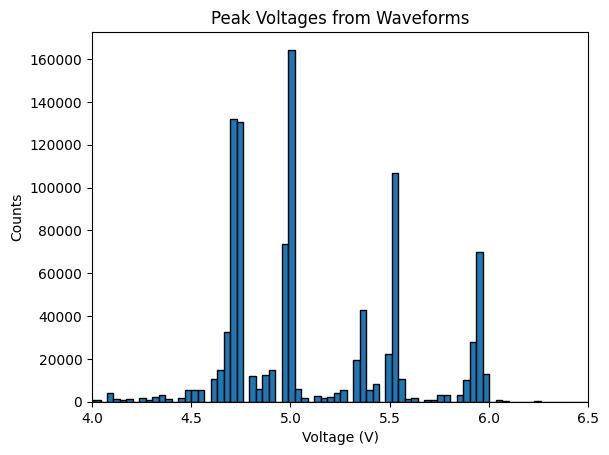

In [25]:
plt.hist(peak_volts, bins=250, edgecolor='black', )
plt.gca().set(xlim=(4, 6.5), xlabel='Voltage (V)', ylabel='Counts', title='Peak Voltages from Waveforms');

# SCA 4.62-5.82 V

In [26]:
path_sca = '/Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82'
files_sca = sorted(glob(path_sca + '/*.wfm'))

In [28]:
peaks_sca = np.array([])
for file in files_sca:
    peaks_sca = np.append(peaks_sca, get_peak_volts(file))

Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82/27052025_SCA_4.62-5.82_100Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82/27052025_SCA_4.62-5.82_10Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82/27052025_SCA_4.62-5.82_11Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82/27052025_SCA_4.62-5.82_12Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62-5.82/27052025_SCA_4.62-5.82_13Wfm.wfm starting at index 0 with step 0.001
Reading 9999999 data points from /Users/pabloherrero/sabat/RaTagging/RaTag/scope_data/waveforms/SCA_4.62

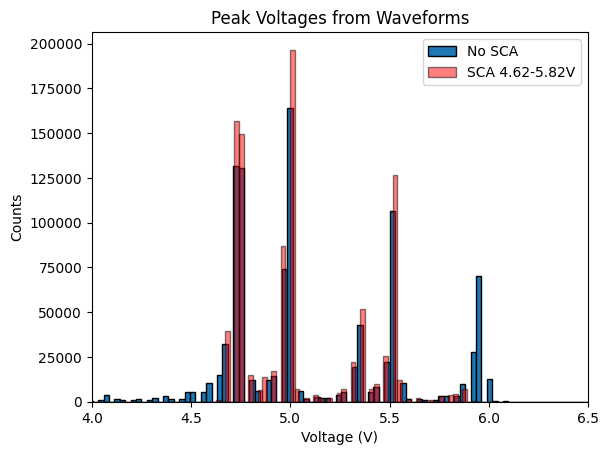

In [31]:
plt.hist(peak_volts, bins=300, edgecolor='black', label='No SCA')
plt.hist(peaks_sca, bins=300, edgecolor='black', color='red', alpha=0.5, label='SCA 4.62-5.82V')
plt.gca().set(xlim=(4, 6.5), xlabel='Voltage (V)', ylabel='Counts', title='Peak Voltages from Waveforms');
plt.legend()